# Testing re-clustering after napari

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_spots(images) :

    if isinstance(images, np.ndarray) :
        images = [images]
    if len(images) > 1 :
        fig, axes = plt.subplots(1, len(images))
    elif len(images) == 1 :
        fig = plt.figure()
        axes = [fig.gca()]

    for ax, im in zip(axes, images) :
        ax.imshow(im)
    plt.show()

## Initializing spots

In [1]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

SEED = 1
random_generator = np.random.default_rng(seed=SEED)

SHAPE = (20,20)
SPOTS_NUM = 40
CLUSTER_RADIUS = 2
MIN_SPOT = 4

image = np.zeros(SHAPE + (3,), dtype=np.uint8)
spots = random_generator.integers([0]*len(SHAPE),SHAPE, (SPOTS_NUM,len(SHAPE)))

spot_image = image.copy()
spot_image[tuple(list(zip(*spots)))] = 255
show_spots([spot_image])

NameError: name 'show_spots' is not defined

## Computing clusters

In [ ]:
dbscan_model = DBSCAN(CLUSTER_RADIUS, min_samples=MIN_SPOT)
dbscan_model.fit(spots)

spots_labels = dbscan_model.labels_.reshape(len(spots),1)

spots_first_clustering = np.concatenate([spots, spots_labels], axis=1)
cluster_number = len(np.unique(spots_first_clustering[:,-1])) - 1
print("{0} clusters found.".format(cluster_number))

2 clusters found.


### Visualisation with clustered spots in red

((9, 15, 16, 9, 14, 8, 8, 15), (10, 19, 18, 9, 19, 10, 12, 18))
[[255   0   0]
 [255   0   0]
 [255   0   0]
 [255   0   0]
 [255   0   0]
 [255   0   0]
 [255   0   0]
 [255   0   0]]


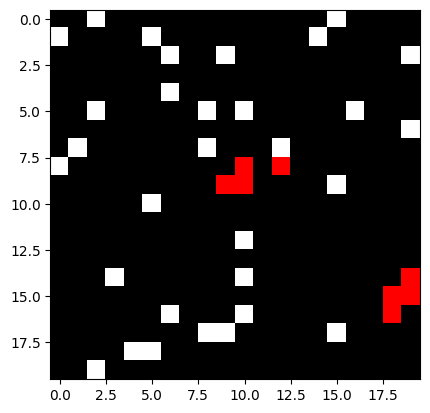

In [ ]:
clustered_spots_index = tuple(list(zip(*spots_first_clustering[:,:-1][spots_first_clustering[:,-1] != -1])))

spot_image[clustered_spots_index] = [255,0,0]

print(clustered_spots_index)
print(spot_image[clustered_spots_index])
show_spots(spot_image)

## Adding a new cluster

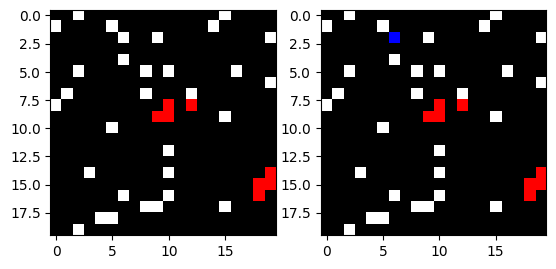

In [ ]:
NEW_CLUSTER_COORDINATES = (2,6) # Shown in blue; in software this is picked by user during Napari correction.
corrected_image = spot_image.copy()
corrected_image[NEW_CLUSTER_COORDINATES] = [0,0,255]
show_spots([spot_image, corrected_image])

### Using sklearn.NearestNeighbours to find spots in radius of new cluster

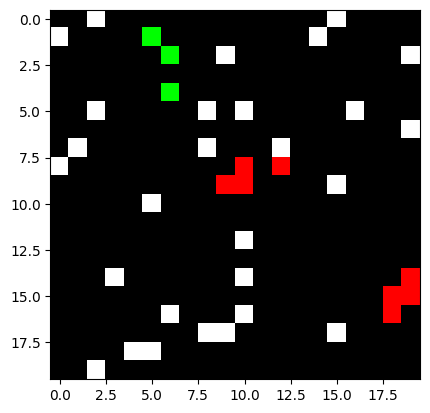

In [ ]:
NearestNeighbors_model = NearestNeighbors(radius=CLUSTER_RADIUS)
NearestNeighbors_model.fit(spots)
query = NearestNeighbors_model.radius_neighbors(np.array([NEW_CLUSTER_COORDINATES], dtype=int), return_distance=False)
neighbours = spots[query[0]]
indexer = tuple(list(
    zip(*neighbours)
))
corrected_image[indexer] = [0,255,0]
show_spots(corrected_image)

## Changing weights so that 2nd round of DBSCAN add the new cluster and only that one.

In [ ]:
weights = np.ones(len(spots), dtype=float) 
number_in_radius = len(neighbours)
weights[query[0]] = MIN_SPOT/number_in_radius # >1
print(weights)

[1.         1.         1.         1.         1.33333333 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.33333333 1.         1.         1.
 1.         1.         1.         1.33333333 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]


In [ ]:
second_dbscan = DBSCAN(CLUSTER_RADIUS, min_samples=MIN_SPOT)
second_dbscan.fit(spots, sample_weight= weights)
spots_labels = second_dbscan.labels_.reshape(len(spots),1)
spots_second_clustering = np.concatenate([spots, spots_labels], axis=1)


### Visualisation with clustered spots in red

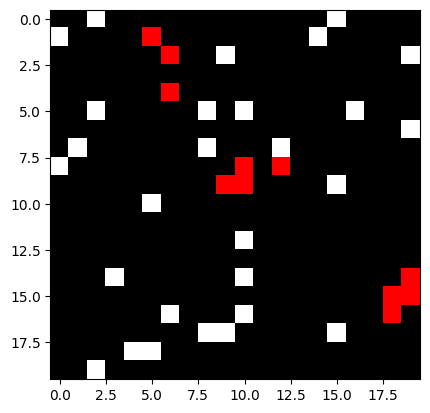

In [ ]:
clustered_spots_index = tuple(list(zip(*spots_second_clustering[:,:-1][spots_second_clustering[:,-1] != -1])))
corrected_image[clustered_spots_index] = [255,0,0]
show_spots(corrected_image)

from bigfish.detection import cluster_detection

# Points layer feature and default features

In [ ]:
import napari
import numpy as np

## Init spots

In [ ]:
SEED = 1
random_generator = np.random.default_rng(seed=SEED)

SHAPE = (100,100)
SPOTS_NUM = 600
CLUSTER_RADIUS = 2
MIN_SPOT = 4

image = np.zeros(SHAPE + (3,), dtype=np.uint8)
spots = random_generator.integers([0]*len(SHAPE),SHAPE, (SPOTS_NUM,len(SHAPE)))
spots_id = np.arange(len(spots))


## Init Viewer

In [ ]:
Viewer = napari.Viewer()
point_layer = Viewer.add_points(
    spots,
    size= 2,
    features={"id" : spots_id},
    feature_defaults={"id" : -1}
)
napari.run()

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x78c1402a7ee0>>
Traceback (most recent call last):
  File "/home/floric/miniconda3/envs/dev/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [ ]:
new_spots_ids = point_layer.features.to_numpy()
new_spots_coord = np.round(point_layer.data).astype(int)
new_spots = np.concatenate([new_spots_coord, new_spots_ids], axis=1)
new_spots   

array([[47, 51,  0],
       [75, 95,  1],
       [ 3, 14,  2],
       ...,
       [27, 62, -1],
       [28, 64, -1],
       [30, 69, -1]])

# Testing napari event

In [ ]:
import os
os.environ["QT_QPA_PLATFORM"] = "xcb"
import numpy as np
import napari

In [ ]:
import napari.layers


viewer = napari.Viewer(title= "Tesing mouse events")

shape = (500,500)

#Adding 2 layers of spots
generator = np.random.default_rng(seed=0)
spots1 = generator.integers(
    low= (0,0),
    high= shape,
    size= (1000,2)
)

spots2 = generator.integers(
    low= (0,0),
    high= shape,
    size= (10,2)
)

cluster_id = generator.integers(
    low=-1,
    high=len(spots2),
    size=len(spots1)
)


layer1 = viewer.add_points(spots1, face_color= 'white', features={'cluster_id' : cluster_id})
layer2 : napari.layers.Points = viewer.add_points(spots2, face_color='red', features={'cluster_id' : np.arange(len(spots2))})

def on_selection_change(event):
    print("Changed!")
    selected_indices = layer2.selected_data
    if len(selected_indices) == 1 :
        idx = list(selected_indices)[0]
        selected_cluster = layer2.features.at[idx,'cluster_id']

        print("selected cluster : ", selected_cluster)

        belonging_spots_index = layer1.features.loc[layer1.features['cluster_id'] == selected_cluster].index.to_numpy()
        layer1.face_color[belonging_spots_index] = [0,1,0,1]
        layer1.refresh()


    else :
        pass
layer2.selected_data.events. .connect(on_selection_change)

viewer.show(block=True)
try :
    viewer.close()
except Exception :
    pass

selected cluster :  3
selected cluster :  4
selected cluster :  3
selected cluster :  1
selected cluster :  6


# Updating segmentation layout

In [10]:
import FreeSimpleGUI as sg

In [11]:
cytoplasm_segmentation_3D = True
nucleus_segmentation_3D = True
is_3D_stack=True

In [19]:
def _segmentation_layout(
        ) :
    
    layout = []

    key_2D = "cyto_radio_2D"
    options_2D = list()
    key_3D = "cyto_radio_3D"
    options_3D = list()
                        
    cyto_radio_2D_seg = sg.Radio("2D segmentation", group_id=1, default=((not cytoplasm_segmentation_3D) or (not is_3D_stack)) or (not is_3D_stack), visible = True, enable_events=True, key=key_2D)
    cyto_radio_max_proj = sg.Radio("max proj", group_id=2, default=False, visible = True)
    cyto_radio_mean_proj = sg.Radio("mean proj", group_id=2, default=True, visible = True)
    cyto_radio_slice_proj = sg.Radio("select slice", group_id=2, default=False, visible = True)
    cyto_int_slice_proj = sg.Spin(list(range(999)), size= (5,1), visible = True, disabled=False)

    options_2D += [cyto_radio_2D_seg, cyto_radio_max_proj, cyto_radio_mean_proj, cyto_radio_slice_proj, cyto_int_slice_proj]

    layout += [
            [cyto_radio_2D_seg],
            [cyto_radio_max_proj, cyto_radio_mean_proj, cyto_radio_slice_proj, cyto_int_slice_proj]
            ]

    if is_3D_stack : 
        cyto_radio_3D_seg = sg.Radio("3D segmentation", group_id=1, default=cytoplasm_segmentation_3D, visible = True,enable_events=True, key=key_3D)
        layout += [[cyto_radio_3D_seg]]

        options_3D += []
    
    layout += [[sg.Button("Ok")]]
                
    #Reference dict
    event_dict = {
        key_2D : options_2D,
        key_3D : options_3D,
    }

    return layout, event_dict

In [20]:
layout,_dict = _segmentation_layout()
window = sg.Window('small fish', layout=layout, margins=(10,10), size=(1000,1000), resizable=False, location=None, enable_close_attempted_event=True)

In [21]:
while True :
    try :
        event, values = window.read(timeout=300, timeout_key="timeout")

        if event == sg.WIN_CLOSE_ATTEMPTED_EVENT or event is None:
            window.close()
            break
        elif event == "Ok" :
            window.close()
            break

        elif event == "cyto_radio_3D" :
            for elmnt in ['cyto_radio_max_proj', 'cyto_radio_mean_proj','cyto_radio_slice_proj','cyto_int_slice_proj'] :
                print(_dict[elmnt])
                _dict[elmnt].update(disabled=True)
        elif event == "cyto_radio_2D" :
            for elmnt in ['cyto_radio_max_proj', 'cyto_radio_mean_proj','cyto_radio_slice_proj','cyto_int_slice_proj'] :
                _dict[elmnt].update(disabled=False)

        elif event != "timeout" :
            print(event)
    
    except Exception as e :
        window.close()
        raise(e)

## Testint custom events on Napari

In [1]:
import os, platform
import napari

system_type = platform.system()


if system_type == "Linux" :
  try :
    os.environ["QT_QPA_PLATFORM"] = "xcb"
  except Exception :
    pass


In [ ]:
from napari.layers import Labels, Points, Image
from napari.utils.events import Event, EmitterGroup
from magicgui import magicgui
from magicgui.widgets import SpinBox, Container

class MyWidgetCreator :
    def __init__(self) :
        self.events = EmitterGroup(source=self, coucou_event = None)
        self.widget = self.create_widget()

    def create_widget(self) :

        @magicgui(
            call_button="coucou"
        )
        def event_emitter(name: str) :
            print("Coucou !!")
            self.events.coucou_event(name=name)
        return event_emitter


class PresenceCounter :
    def __init__(self) :
        self.value = 0
    
    def _on_salutation(self, event) :
        self.value += 1
        print(f"{event.name} arrived! We are {self.value} now!")

In [ ]:
Viewer = napari.Viewer()
my_widget = MyWidgetCreator()
presence_counter = PresenceCounter()

my_widget.events.coucou_event.connect(presence_counter._on_salutation)
Viewer.window.add_dock_widget(my_widget.widget, name='test')

napari.run()

Coucou !!
F arrived! We are 1 now!
Coucou !!
R arrived! We are 2 now!
Coucou !!
R arrived! We are 3 now!
Coucou !!
D arrived! We are 4 now!
Coucou !!
G arrived! We are 5 now!
